In [1]:
## -- Set Device-Agnostic code --
import torch
print(f"ℹ️ Cuda available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    get_ipython().run_line_magic('load_ext', 'cuml.accel')
else:
    pass

ℹ️ Cuda available: True
[2025-10-31 23:06:23.289] [CUML] [info] cuML: Installed accelerator for sklearn.


2025-10-31 23:06:39.220610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761951999.415735      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761951999.472728      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[2025-10-31 23:06:56.934] [CUML] [info] cuML: Installed accelerator for umap.
[2025-10-31 23:06:57.018] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-10-31 23:06:57.018] [CUML] [info] cuML: Successfully initialized accelerator.


In [2]:
## -- IMPORT LIBRARIES --
import sys, os, gc

## -- DATA MANIPUALATION --
import numpy as np, pandas as pd, random

## -- VISUALISATION --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## -- FUNCTIONAL TOOLS --
from itertools import combinations, product
from tqdm.notebook import tqdm
from time import time, sleep

## -- MACHINE LEARNING --
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay

if torch.cuda.is_available():
    import cuml
    from cuml.preprocessing import TargetEncoder as cuTE
else:
    from sklearn.preprocessing import TargetEncoder as sciTE

import lightgbm as lgb

import warnings

In [3]:
print(f"lightgbm version: {lgb.__version__}")
print(f"sklearn version: {sklearn.__version__}")
print(f"shap version: {shap.__version__}")

lightgbm version: 4.6.0
sklearn version: 1.7.2
shap version: 0.44.1


In [4]:
## --- GLOBAL SETTINGS --- ##
sklearn.set_config(transform_output="pandas")

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
# pd.options.mode.copy_on_write = True
# plt.style.use("whitegrid")

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

In [5]:
## -- Load Data --
PATH = "/kaggle/input/playground-series-s5e10/"
train= pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)
submit = pd.read_csv(PATH+"sample_submission.csv")

ORIG_PATH = "/kaggle/input/simulated-roads-accident-data/"
orig = pd.concat([pd.read_csv(ORIG_PATH+"synthetic_road_accidents_100k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_10k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_2k.csv")],
            ignore_index=True)

TARGET = "accident_risk"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
FEATURES = NUMS + CATS

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} has shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")

Train has shape: (517754, 13)
Test has shape: (172585, 12)
Original has shape: (112000, 13)

Total Numerical: 4
Total Categorical: 8


In [6]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [7]:
## -- Unique value counts per dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in test.columns:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient(cmap='Spectral')

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
Train,3,4,261,5,3,3,2,2,3,2,2,8
Original,3,4,101,5,3,3,2,2,3,2,2,11
Test,3,4,195,5,3,3,2,2,3,2,2,8


### FEATURE ENGINEERING

In [8]:
# ## -- meta feature --
# for df in [train, test, orig]:
#     base_risk = (
#         0.3 * df["curvature"] +
#         0.2 * (df["lighting"] == "night").astype(int) +
#         0.1 * (df["weather"] != "clear").astype(int) +
#         0.2 * (df["speed_limit"] >= 60).astype(int) +
#         0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
#             )
#     df['meta'] = base_risk

# BINARY_COLS = [c for c in test.columns if test[c].nunique() == 2]
# # for df in [train, test]:
# #     df['BINARY'] = 0
# #     for i in range(len(BINARY_COLS)):
# #         df['BINARY'] += df[BINARY_COLS[i]].astype(int) * (2**i)

# FEATURES.append('meta')
# print(f"✅ 'meta' feature created!")
# # print(f"✅ 'BINARY' feature created!")

In [9]:
combine = pd.concat([train, orig, test], axis=0, ignore_index=True)
combine.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [10]:
# -- Generate 'base_score' predictions as feature --
from scipy.stats import norm

def f(X):
    return \
    0.3 * X["curvature"] + \
    0.2 * (X["lighting"] == "night").astype(int) + \
    0.1 * (X["weather"] != "clear").astype(int) + \
    0.2 * (X["speed_limit"] >= 60).astype(int) + \
    0.1 * (X["num_reported_accidents"] > 2).astype(int)

def clip(f):
    def clip_f(X):
        sigma = 0.05
        mu = f(X)
        a, b = -mu/sigma, (1-mu)/sigma
        Phi_a, Phi_b = norm.cdf(a), norm.cdf(b)
        phi_a, phi_b = norm.pdf(a), norm.pdf(b)
        return mu*(Phi_b-Phi_a)+sigma*(phi_a-phi_b)+1-Phi_b
    return clip_f


meta = clip(f)(combine)
combine["base_score"] = meta.values

print(f"√'base_score' feature created")
FEATURES.append("base_score")
# FEATURES
combine.head(10)

√'base_score' feature created


,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,base_score
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13,0.118153
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35,0.297000
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30,0.389000
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21,0.121128
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56,0.474000
5,highway,3,0.54,70,night,foggy,True,False,morning,False,True,0,0.61,0.662000
6,highway,1,0.04,45,night,foggy,False,True,morning,True,False,2,0.20,0.312000
7,highway,2,0.33,45,daylight,clear,False,True,evening,False,True,0,0.16,0.099448
8,rural,3,0.63,25,dim,clear,True,False,evening,True,True,2,0.18,0.189001
9,urban,4,0.38,45,dim,clear,True,True,afternoon,True,True,2,0.15,0.114194


In [11]:
## -- Use string conversion to check float values --
combine['base_score'].astype(str).head(20)

0     0.118153342
1           0.297
2           0.389
3     0.121128045
4           0.474
5           0.662
6           0.312
7     0.099447832
8     0.189000927
9     0.114194091
10    0.135053005
11          0.378
12          0.352
13          0.342
14    0.124106595
15          0.356
16    0.205000228
17          0.504
18          0.716
19    0.757999994
Name: base_score, dtype: object

In [12]:
# ## -- Put Numerical Column into Bins --
# ROUND = []
# for k in range(11,17):
#     n = f"r-{k}"
#     combine[n] = combine["base_score"].round(k)
#     ROUND.append(n)

# print(f"Rounded Features: {len(ROUND)}")

In [13]:
# ## -- Extract Float32 as Digits --
# DIGITS = []
# for k in range(1, 10):
#     n = f'd-{k}'
#     combine[n] = ((combine["base_score"] * 10**k) % 10).fillna(-1).astype("int8")
#     DIGITS.append(n)

# print(f"Rounded Features: {len(DIGITS)}")

In [14]:
combine.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,base_score
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13,0.118153
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35,0.297000
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30,0.389000
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21,0.121128
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56,0.474000


In [15]:
train = combine[:len(train)]
orig = combine[len(train):len(train)+len(orig)]
test = combine[-len(test):].drop(TARGET, axis=1)

In [16]:
## -- FEATURE 1: Use original as features
FEAT = [c for c in orig.columns if c not in [TARGET]] # Exclude binned features
print(f"Merging {len(FEAT)} features: ", end="")
STATS = ['mean'] #,'count','nunique','max','min',
for c in FEAT:
    print(f"{c}, ", end="")
    tmp = orig.groupby(c)[TARGET].agg(STATS)
    tmp.columns = [f'OTE_{c}_{s.upper()}' for s in STATS]
    train = train.merge(tmp, on=c, how='left')
    test  = test.merge(tmp, on=c, how='left')

Merging 13 features: road_type, num_lanes, curvature, speed_limit, lighting, weather, road_signs_present, public_road, time_of_day, holiday, school_season, num_reported_accidents, base_score, 

In [17]:
## -- Factorize using combined data --
for c in CATS:
    combined = pd.concat([train[c], test[c]], axis=0, ignore_index=True)
    combined = combined.factorize()[0]
    train[c] = combined[:len(train)]
    test[c]  = combined[len(train):]

print(f"✅ Label encoded {len(CATS)} features.")

✅ Label encoded 8 features.


In [18]:
# BINS = []
# print(f"\nCreating bins... ", end="")
# for c in ['curvature']:
#     for b in [10]:
#         print(f"{c}_{b}, ", end="")
#         b_n = f'{c}_b{b}'
#         # Fit on train data and transform both train and test
#         bins = np.linspace(train[c].min(), train[c].max(), b+1)
#         train[b_n] = pd.cut(train[c], include_lowest=True, labels=False, bins=bins)
#         test[b_n] = pd.cut(test[c], include_lowest=True, labels=False, bins=bins)
#         BINS.append(b_n)
# print()
# print(f"✅ {len(BINS)} binned features created!")

In [19]:
# ## -- Pairwise combinations --
# # MASTER_COLS = ['curvature', 'meta']
# SLAVE_COLS  = [x for x in FEATURES if x not in ['curvature', 'meta']]
# master_slave_pairs = list(product(BINS, SLAVE_COLS))

# TE1 = []
# for c in tqdm(master_slave_pairs, desc="Creating Master-Slave Pairwise"):
#     # The order of the columns in 'c' is (master, slave)
#     c1 = c[0] # Master Column
#     c2 = c[1] # Slave Column
#     n = f'TE1_{c1}-|-{c2}'
#     train[n] = train[c1].astype(str) + '_' + train[c2].astype(str)
#     test[n]  = test[c1].astype(str)  + '_' + test[c2].astype(str)
#     train[n] = train[n].astype('category')
#     cat = train[n].cat
#     train[n] = train[n].cat.codes
#     test[n]  = pd.Categorical(test[n], categories=cat.categories).codes
#     TE1.append(n)

# print(f"✅ TE1 features: {len(TE1)}")

In [20]:
## -- Heatmap Plot --
# plt.figure(figsize=(20, 15))
# sns.heatmap(train.corr(), mask=np.triu(train.corr()), annot=True, fmt='.2f', cbar=False)
# plt.tight_layout()
# plt.show()

In [21]:
## -- Pairwise combinations --
TE2 = []
# COLS = [c for c in FEATURES if c not in BINARY_COLS]
for c in tqdm(list(combinations(FEATURES, 2)), desc="Creating Pairwise"):
    n = f'TE2_'+'-|-'.join(c)
    train[n] = train[c[0]].astype(str) + '_' + train[c[1]].astype(str)
    test[n]  = test[c[0]].astype(str) + '_' + test[c[1]].astype(str)
    train[n] = train[n].astype('category')
    cat = train[n].cat
    # train[n] = train[n].cat.codes
    test[n]  = pd.Categorical(test[n], categories=cat.categories)#.codes
    TE2.append(n)

Creating Pairwise:   0%|          | 0/78 [00:00<?, ?it/s]

In [22]:
## -- Triplewise combinations --
TOP_PREDICTORS = ['base_score', 'curvature','lighting','speed_limit','weather','num_reported_accidents']
TE3 = []
for c in tqdm(list(combinations(TOP_PREDICTORS, 3)), desc="Creating Triplewise"):
    n = f'TE3_'+'-|-'.join(c)
    train[n] = train[c[0]].astype(str) + '_' + \
               train[c[1]].astype(str) + '_' + \
               train[c[2]].astype(str)
    test[n]  = test[c[0]].astype(str) + '_' + \
               test[c[1]].astype(str) + '_' + \
               test[c[2]].astype(str)

    train[n] = train[n].astype('category')
    cat = train[n].cat
    # train[n] = train[n].cat.codes
    test[n] = pd.Categorical(test[n], categories=cat.categories)#.codes
    TE3.append(n)

Creating Triplewise:   0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
len(TE2), len(TE3)

(78, 20)

In [24]:
__ = [c for c in train.columns if train[c].nunique() < 2]
print(f"Produced {len(__)} single value features: {__}")
train = train.drop(__, axis=1)
test = test.drop(__, axis=1)
print(f"Drop {len(__)} columns... Complete!")

Produced 0 single value features: []
Drop 0 columns... Complete!


In [25]:
display(train.sample(20))
# display(train.info())
train.shape, test.shape

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,base_score,OTE_road_type_MEAN,OTE_num_lanes_MEAN,OTE_curvature_MEAN,OTE_speed_limit_MEAN,OTE_lighting_MEAN,OTE_weather_MEAN,OTE_road_signs_present_MEAN,OTE_public_road_MEAN,OTE_time_of_day_MEAN,OTE_holiday_MEAN,OTE_school_season_MEAN,OTE_num_reported_accidents_MEAN,OTE_base_score_MEAN,TE2_num_lanes-|-curvature,TE2_num_lanes-|-speed_limit,TE2_num_lanes-|-num_reported_accidents,TE2_num_lanes-|-road_type,TE2_num_lanes-|-lighting,TE2_num_lanes-|-weather,TE2_num_lanes-|-road_signs_present,TE2_num_lanes-|-public_road,TE2_num_lanes-|-time_of_day,TE2_num_lanes-|-holiday,TE2_num_lanes-|-school_season,TE2_num_lanes-|-base_score,TE2_curvature-|-speed_limit,TE2_curvature-|-num_reported_accidents,TE2_curvature-|-road_type,TE2_curvature-|-lighting,TE2_curvature-|-weather,TE2_curvature-|-road_signs_present,TE2_curvature-|-public_road,TE2_curvature-|-time_of_day,TE2_curvature-|-holiday,TE2_curvature-|-school_season,TE2_curvature-|-base_score,TE2_speed_limit-|-num_reported_accidents,TE2_speed_limit-|-road_type,TE2_speed_limit-|-lighting,TE2_speed_limit-|-weather,TE2_speed_limit-|-road_signs_present,TE2_speed_limit-|-public_road,TE2_speed_limit-|-time_of_day,TE2_speed_limit-|-holiday,TE2_speed_limit-|-school_season,TE2_speed_limit-|-base_score,TE2_num_reported_accidents-|-road_type,TE2_num_reported_accidents-|-lighting,TE2_num_reported_accidents-|-weather,TE2_num_reported_accidents-|-road_signs_present,TE2_num_reported_accidents-|-public_road,TE2_num_reported_accidents-|-time_of_day,TE2_num_reported_accidents-|-holiday,TE2_num_reported_accidents-|-school_season,TE2_num_reported_accidents-|-base_score,TE2_road_type-|-lighting,TE2_road_type-|-weather,TE2_road_type-|-road_signs_present,TE2_road_type-|-public_road,TE2_road_type-|-time_of_day,TE2_road_type-|-holiday,TE2_road_type-|-school_season,TE2_road_type-|-base_score,TE2_lighting-|-weather,TE2_lighting-|-road_signs_present,TE2_lighting-|-public_road,TE2_lighting-|-time_of_day,TE2_lighting-|-holiday,TE2_lighting-|-school_season,TE2_lighting-|-base_score,TE2_weather-|-road_signs_present,TE2_weather-|-public_road,TE2_weather-|-time_of_day,TE2_weather-|-holiday,TE2_weather-|-school_season,TE2_weather-|-base_score,TE2_road_signs_present-|-public_road,TE2_road_signs_present-|-time_of_day,TE2_road_signs_present-|-holiday,TE2_road_signs_present-|-school_season,TE2_road_signs_present-|-base_score,TE2_public_road-|-time_of_day,TE2_public_road-|-holiday,TE2_public_road-|-school_season,TE2_public_road-|-base_score,TE2_time_of_day-|-holiday,TE2_time_of_day-|-school_season,TE2_time_of_day-|-base_score,TE2_holiday-|-school_season,TE2_holiday-|-base_score,TE2_school_season-|-base_score,TE3_base_score-|-curvature-|-lighting,TE3_base_score-|-curvature-|-speed_limit,TE3_base_score-|-curvature-|-weather,TE3_base_score-|-curvature-|-num_reported_accidents,TE3_base_score-|-lighting-|-speed_limit,TE3_base_score-|-lighting-|-weather,TE3_base_score-|-lighting-|-num_reported_accidents,TE3_base_score-|-speed_limit-|-weather,TE3_base_score-|-speed_limit-|-num_reported_accidents,TE3_base_score-|-weather-|-num_reported_accidents,TE3_curvature-|-lighting-|-speed_limit,TE3_curvature-|-lighting-|-weather,TE3_curvature-|-lighting-|-num_reported_accidents,TE3_curvature-|-speed_limit-|-weather,TE3_curvature-|-speed_limit-|-num_reported_accidents,TE3_curvature-|-weather-|-num_reported_accidents,TE3_lighting-|-speed_limit-|-weather,TE3_lighting-|-speed_limit-|-num_reported_accidents,TE3_lighting-|-weather-|-num_reported_accidents,TE3_speed_limit-|-weather-|-num_reported_accidents
140131,0,4,0.75,25,1,0,0,1,2,1,0,2,0.33,0.325000,0.383942,0.383503,0.462374,0.302511,0.316692,0.417100,0.383140,0.383545,0.381874,0.382695,0.382813,0.363730,0.324610,4_0.75,4_25,4_2,4_0,4_1,4_0,4_0,4_1,4_2,4_1,4_0,4_0.325,0.75_25,0.75_2,0.75_0,0.75_1,0.75_0,0.75_0,0.75_1,0.75_2,0.75_1,0.75_0,0.75_

((517754, 125), (172585, 124))

### MODEL TRAINING

In [26]:
## -- DEFINE TRAINING PARAMETERS --
params = dict( # Bagging -
    data_sample_strategy = "bagging",
    bagging_fraction = 0.8,
    feature_fraction = 0.5,
    max_depth = 7,
    max_leaves = 65,
    min_data_in_leaf = 40,
    eta = 0.005, 
    objective = "regression",
    metric = "rmse",
    verbose = -1,
    n_jobs = -1,
    device_type = "gpu",
)

# params = dict( # Goss -
#     data_sample_strategy = "goss",
#     top_rate = 0.7,
#     other_rate = 0.2,
#     max_depth = 7,
#     max_leaves = 64,
#     min_data_in_leaf = 50,
#     eta = 0.005,
#     verbose = -1,
#     n_jobs = -1,
#     objective = "regression",
#     metric = "rmse",
#     device_type = "gpu",
# )

ℹ️ Device GPU: Tesla T4
ℹ️ No. of CPU: 4 cores
|---------------------------------
	Fold 1 #####


Target Encoding:   0%|          | 0/98 [00:00<?, ?it/s]

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 250 rounds
[200]	train's rmse: 0.0567021	valid's rmse: 0.0566762
[400]	train's rmse: 0.056233	valid's rmse: 0.0562786
[600]	train's rmse: 0.0560197	valid's rmse: 0.0561373
[800]	train's rmse: 0.0558867	valid's rmse: 0.0560711
[1000]	train's rmse: 0.0557735	valid's rmse: 0.0560237
[1200]	train's rmse: 0.0556822	valid's rmse: 0.0559926
[1400]	train's rmse: 0.0556005	valid's rmse: 0.0559703
[1600]	train's rmse: 0.0555248	valid's rmse: 0.0559577
[1800]	train's rmse: 0.0554504	valid's rmse: 0.0559453
[2000]	train's rmse: 0.0553814	valid's rmse: 0.0559358
[2200]	train's rmse: 0.0553143	valid's rmse: 0.0559287
[2400]	train's rmse: 0.0552471	valid's rmse: 0.0559208
[2600]	train's rmse: 0.0551874	valid's rmse: 0.0559175
[2800]	train's rmse: 0.0551265	valid's rmse: 0.0559145
[3000]	train's rmse: 0.0550695	valid's rmse: 0.0559124
[3200]	train's rmse: 0.0550141	valid's rmse: 0.0559111
[3400]	train's rmse: 0.0549598	valid's rmse: 0.0559102
[3600]	t

Target Encoding:   0%|          | 0/98 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
[200]	train's rmse: 0.0565781	valid's rmse: 0.0573009
[400]	train's rmse: 0.0561197	valid's rmse: 0.0568879
[600]	train's rmse: 0.0559211	valid's rmse: 0.0567446
[800]	train's rmse: 0.0557886	valid's rmse: 0.0566696
[1000]	train's rmse: 0.0556756	valid's rmse: 0.0566159
[1200]	train's rmse: 0.0555796	valid's rmse: 0.056574
[1400]	train's rmse: 0.0554963	valid's rmse: 0.056547
[1600]	train's rmse: 0.05542	valid's rmse: 0.0565266
[1800]	train's rmse: 0.0553506	valid's rmse: 0.0565124
[2000]	train's rmse: 0.0552813	valid's rmse: 0.0564974
[2200]	train's rmse: 0.0552189	valid's rmse: 0.0564871
[2400]	train's rmse: 0.0551569	valid's rmse: 0.0564769
[2600]	train's rmse: 0.0550977	valid's rmse: 0.0564708
[2800]	train's rmse: 0.0550418	valid's rmse: 0.0564644
[3000]	train's rmse: 0.0549834	valid's rmse: 0.0564587
[3200]	train's rmse: 0.0549289	valid's rmse: 0.0564554
[3400]	train's rmse: 0.0548752	valid's rmse: 0.0564527
[3600]	trai

Target Encoding:   0%|          | 0/98 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
[200]	train's rmse: 0.0567266	valid's rmse: 0.0564798
[400]	train's rmse: 0.0562515	valid's rmse: 0.0561095
[600]	train's rmse: 0.0560382	valid's rmse: 0.0559786
[800]	train's rmse: 0.0559011	valid's rmse: 0.055917
[1000]	train's rmse: 0.0557864	valid's rmse: 0.0558736
[1200]	train's rmse: 0.0556881	valid's rmse: 0.0558434
[1400]	train's rmse: 0.0555984	valid's rmse: 0.0558211
[1600]	train's rmse: 0.0555203	valid's rmse: 0.0558063
[1800]	train's rmse: 0.0554485	valid's rmse: 0.0557959
[2000]	train's rmse: 0.0553776	valid's rmse: 0.0557844
[2200]	train's rmse: 0.0553107	valid's rmse: 0.0557762
[2400]	train's rmse: 0.0552446	valid's rmse: 0.0557693
[2600]	train's rmse: 0.0551802	valid's rmse: 0.055764
[2800]	train's rmse: 0.0551183	valid's rmse: 0.0557594
[3000]	train's rmse: 0.055062	valid's rmse: 0.0557567
[3200]	train's rmse: 0.0550056	valid's rmse: 0.0557553
[3400]	train's rmse: 0.0549494	valid's rmse: 0.0557541
[3600]	tra

Target Encoding:   0%|          | 0/98 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
[200]	train's rmse: 0.0566588	valid's rmse: 0.0568423
[400]	train's rmse: 0.056195	valid's rmse: 0.0564442
[600]	train's rmse: 0.0559817	valid's rmse: 0.0563043
[800]	train's rmse: 0.0558488	valid's rmse: 0.0562409
[1000]	train's rmse: 0.0557286	valid's rmse: 0.0561919
[1200]	train's rmse: 0.0556287	valid's rmse: 0.05616
[1400]	train's rmse: 0.0555499	valid's rmse: 0.0561415
[1600]	train's rmse: 0.0554732	valid's rmse: 0.0561259
[1800]	train's rmse: 0.0554015	valid's rmse: 0.0561144
[2000]	train's rmse: 0.0553352	valid's rmse: 0.0561058
[2200]	train's rmse: 0.0552715	valid's rmse: 0.0560985
[2400]	train's rmse: 0.05521	valid's rmse: 0.0560929
[2600]	train's rmse: 0.0551514	valid's rmse: 0.0560896
[2800]	train's rmse: 0.0550961	valid's rmse: 0.056087
[3000]	train's rmse: 0.0550389	valid's rmse: 0.0560831
[3200]	train's rmse: 0.0549871	valid's rmse: 0.056082
[3400]	train's rmse: 0.0549336	valid's rmse: 0.0560812
[3600]	train's

Target Encoding:   0%|          | 0/98 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
[200]	train's rmse: 0.0566889	valid's rmse: 0.0566704
[400]	train's rmse: 0.0562209	valid's rmse: 0.0563084
[600]	train's rmse: 0.0560094	valid's rmse: 0.0561839
[800]	train's rmse: 0.0558749	valid's rmse: 0.0561291
[1000]	train's rmse: 0.0557592	valid's rmse: 0.0560874
[1200]	train's rmse: 0.0556624	valid's rmse: 0.05606
[1400]	train's rmse: 0.0555758	valid's rmse: 0.0560413
[1600]	train's rmse: 0.0554972	valid's rmse: 0.0560289
[1800]	train's rmse: 0.0554222	valid's rmse: 0.0560171
[2000]	train's rmse: 0.0553504	valid's rmse: 0.0560086
[2200]	train's rmse: 0.0552861	valid's rmse: 0.0560035
[2400]	train's rmse: 0.0552201	valid's rmse: 0.0559961
[2600]	train's rmse: 0.0551636	valid's rmse: 0.0559932
[2800]	train's rmse: 0.0551037	valid's rmse: 0.0559892
[3000]	train's rmse: 0.0550493	valid's rmse: 0.0559862
[3200]	train's rmse: 0.0549938	valid's rmse: 0.0559854
[3400]	train's rmse: 0.0549391	valid's rmse: 0.0559838
[3600]	tr

Target Encoding:   0%|          | 0/98 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
[200]	train's rmse: 0.0566918	valid's rmse: 0.0567198
[400]	train's rmse: 0.0562306	valid's rmse: 0.0563036
[600]	train's rmse: 0.0560098	valid's rmse: 0.0561452
[800]	train's rmse: 0.0558752	valid's rmse: 0.0560737
[1000]	train's rmse: 0.0557658	valid's rmse: 0.0560254
[1200]	train's rmse: 0.0556683	valid's rmse: 0.055991
[1400]	train's rmse: 0.0555827	valid's rmse: 0.0559679
[1600]	train's rmse: 0.0555049	valid's rmse: 0.0559483
[1800]	train's rmse: 0.055431	valid's rmse: 0.055933
[2000]	train's rmse: 0.0553616	valid's rmse: 0.0559225
[2200]	train's rmse: 0.0552927	valid's rmse: 0.0559118
[2400]	train's rmse: 0.0552253	valid's rmse: 0.0559039
[2600]	train's rmse: 0.0551622	valid's rmse: 0.0558991
[2800]	train's rmse: 0.0551004	valid's rmse: 0.0558947
[3000]	train's rmse: 0.0550428	valid's rmse: 0.0558925
[3200]	train's rmse: 0.0549858	valid's rmse: 0.0558909
[3400]	train's rmse: 0.054931	valid's rmse: 0.0558892
[3600]	trai

Target Encoding:   0%|          | 0/98 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
[200]	train's rmse: 0.0567144	valid's rmse: 0.0565803
[400]	train's rmse: 0.0562593	valid's rmse: 0.0561735
[600]	train's rmse: 0.0560469	valid's rmse: 0.0560191
[800]	train's rmse: 0.0559108	valid's rmse: 0.0559534
[1000]	train's rmse: 0.0557928	valid's rmse: 0.0559035
[1200]	train's rmse: 0.0556924	valid's rmse: 0.0558689
[1400]	train's rmse: 0.0556043	valid's rmse: 0.0558419
[1600]	train's rmse: 0.0555233	valid's rmse: 0.0558251
[1800]	train's rmse: 0.0554451	valid's rmse: 0.0558093
[2000]	train's rmse: 0.055374	valid's rmse: 0.0557978
[2200]	train's rmse: 0.0553061	valid's rmse: 0.0557879
[2400]	train's rmse: 0.055242	valid's rmse: 0.05578
[2600]	train's rmse: 0.0551811	valid's rmse: 0.0557739
[2800]	train's rmse: 0.0551256	valid's rmse: 0.0557708
[3000]	train's rmse: 0.0550689	valid's rmse: 0.0557677
[3200]	train's rmse: 0.0550131	valid's rmse: 0.0557641
[3400]	train's rmse: 0.0549584	valid's rmse: 0.0557622
[3600]	trai

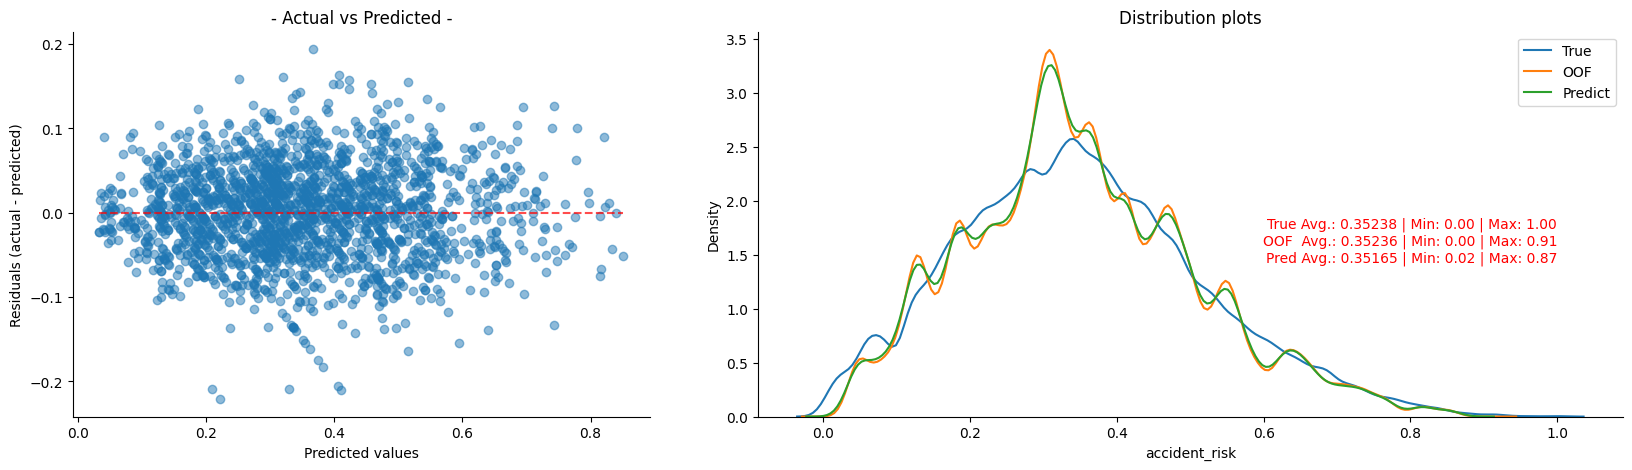

Training Time: 26.27 mins =========================


In [27]:
## -- DEFINE TRAINING PARAMETERS --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")
## -----------------------------------------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true.values, y_pred))

oof_preds   = np.zeros(len(train))
test_preds  = np.zeros(len(test))
fold_scores = []

X = train.drop(TARGET, axis=1)
y = train[TARGET]

FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
rand_seeds = np.ceil(np.linspace(3, 911, FOLDS)).astype(int)

## -- Initiate Training -- 
tik = time()
for fold, (t_idx, v_idx) in enumerate(kf.split(X)):
    print(f"|{'-'*33}")
    print(f"\t{COLOR}Fold {fold+1} {'#'*5}{RESET}")

    X_train, X_val = X.iloc[t_idx], X.iloc[v_idx]
    y_train, y_val = y.iloc[t_idx], y.iloc[v_idx]

    X_train_enc = X_train.copy()
    X_val_enc   = X_val.copy()
    test_enc    = test.copy()

    ## -- Target Encoding --
    for col in tqdm(TE2+TE3, desc="Target Encoding", leave=False):
        if torch.cuda.is_available(): # -> GPU
            TE_enc = cuTE(n_folds=5, smooth=0.1, split_method='random')
        else: # -> CPU
            TE_enc = sciTE(cv=5, smooth=10, random_state=SEED)
            # TE_enc = ceTE(cols=[col], smoothing=5)
        X_train_enc[col] = TE_enc.fit_transform(X_train_enc[[col]], y_train).astype('float32')
        X_val_enc[col]   = TE_enc.transform(X_val_enc[[col]]).astype('float32')
        test_enc[col]    = TE_enc.transform(test_enc[[col]]).astype('float32')

    X_train_enc[CATS] = X_train_enc[CATS].astype("category")
    X_val_enc[CATS]   = X_val_enc[CATS].astype("category")
    test_enc[CATS]    = test_enc[CATS].astype("category")

    params['seed'] = rand_seeds[fold] 

    ## -- Create Pool objects --
    dtrain = lgb.Dataset(
        data=X_train_enc,
        label=y_train,
        init_score=X_train_enc["base_score"].values,
        categorical_feature=CATS)
    dval = lgb.Dataset(
        data=X_val_enc,
        label=y_val,
        reference=dtrain,
        init_score=X_val_enc["base_score"].values,
        categorical_feature=CATS)
    dtest = lgb.Dataset(
        data=test_enc,
        init_score=test_enc["base_score"].values,
        categorical_feature=CATS)

    model = lgb.train(
                params,
                dtrain,
                num_boost_round=20000,
                valid_sets=[dtrain, dval],
                valid_names=["train", "valid"],
                callbacks=[lgb.early_stopping(stopping_rounds=250),
                           lgb.log_evaluation(period=200)],
    )
    y_pred = model.predict(X_val_enc, num_iteration=model.best_iteration)
    oof_preds[v_idx] = np.clip(y_pred+X_val_enc["base_score"].values, 0, 1)
    predictions = model.predict(test_enc, num_iteration=model.best_iteration)
    test_preds += np.clip(predictions+test_enc["base_score"].values, 0, 1) / FOLDS

    ## -- Compute RMSE for validation fold --
    fold_rmse = rmse(y_val, y_pred+X_val_enc["base_score"].values)
    fold_scores.append(fold_rmse)
    print(f"\t{COLOR}RMSE Score: {fold_rmse:.6f}{RESET}")

    sleep(2); gc.collect(); sleep(2) # Rest. Clean. Repeat.

## -- After all folds --
overall_score = rmse(y, oof_preds)
print(f"|{'-'*50}{COLOR}")
print(f"| Total No.features: {len(X_train_enc.columns)}")
print(f"| Overall OOF  RMSE: {overall_score:.6f}")
print(f"| Average Fold RMSE: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}{RESET}")

## -- Plot predictions errors --
GRID_ = dict(width_ratios=[0.4, 0.6], wspace=0.15)
fig, axs = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw=GRID_)
display = PredictionErrorDisplay.from_predictions(
    y, oof_preds, ax=axs[0], subsample=2000,
    # kind = "actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5}, line_kwargs={'color': 'r'},
        )
axs[0].set_title(f"- Actual vs Predicted -")

LABELS = ['True', 'OOF', 'Predict']
sns.kdeplot(y, ax=axs[1], label=LABELS[0])
sns.kdeplot(oof_preds, ax=axs[1], label=LABELS[1])
sns.kdeplot(test_preds, ax=axs[1], label=LABELS[2])
axs[1].set_title(f"Distribution plots")
TEXT = f"""
True Avg.: {np.mean(y):.5f} | Min: {np.min(y):.2f} | Max: {np.max(y):.2f}
OOF  Avg.: {np.mean(oof_preds):.5f} | Min: {np.min(oof_preds):.2f} | Max: {np.max(oof_preds):.2f}
Pred Avg.: {np.mean(test_preds):.5f} | Min: {np.min(test_preds):.2f} | Max: {np.max(test_preds):.2f}
        """
axs[1].text(x=1, y=2, s=TEXT, ha='right', va='top', color='r')

for ax in axs:
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.legend() 
plt.tight_layout()
plt.show()

name = f"lgbGres_" + f"{overall_score:.6f}".split('.')[1]
oof_final  = pd.DataFrame(oof_preds, columns=[name])
test_final = pd.DataFrame(test_preds, columns=[name])

tok = time()
tiktok = (tok-tik)/60
print(f"Training Time: {tiktok:.2f} mins {'='*25}")

In [28]:
X_train_enc.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 443790 entries, 0 to 517753
Columns: 124 entries, road_type to TE3_speed_limit-|-weather-|-num_reported_accidents
dtypes: category(8), float32(98), float64(15), int64(3)
memory usage: 233.6 MB


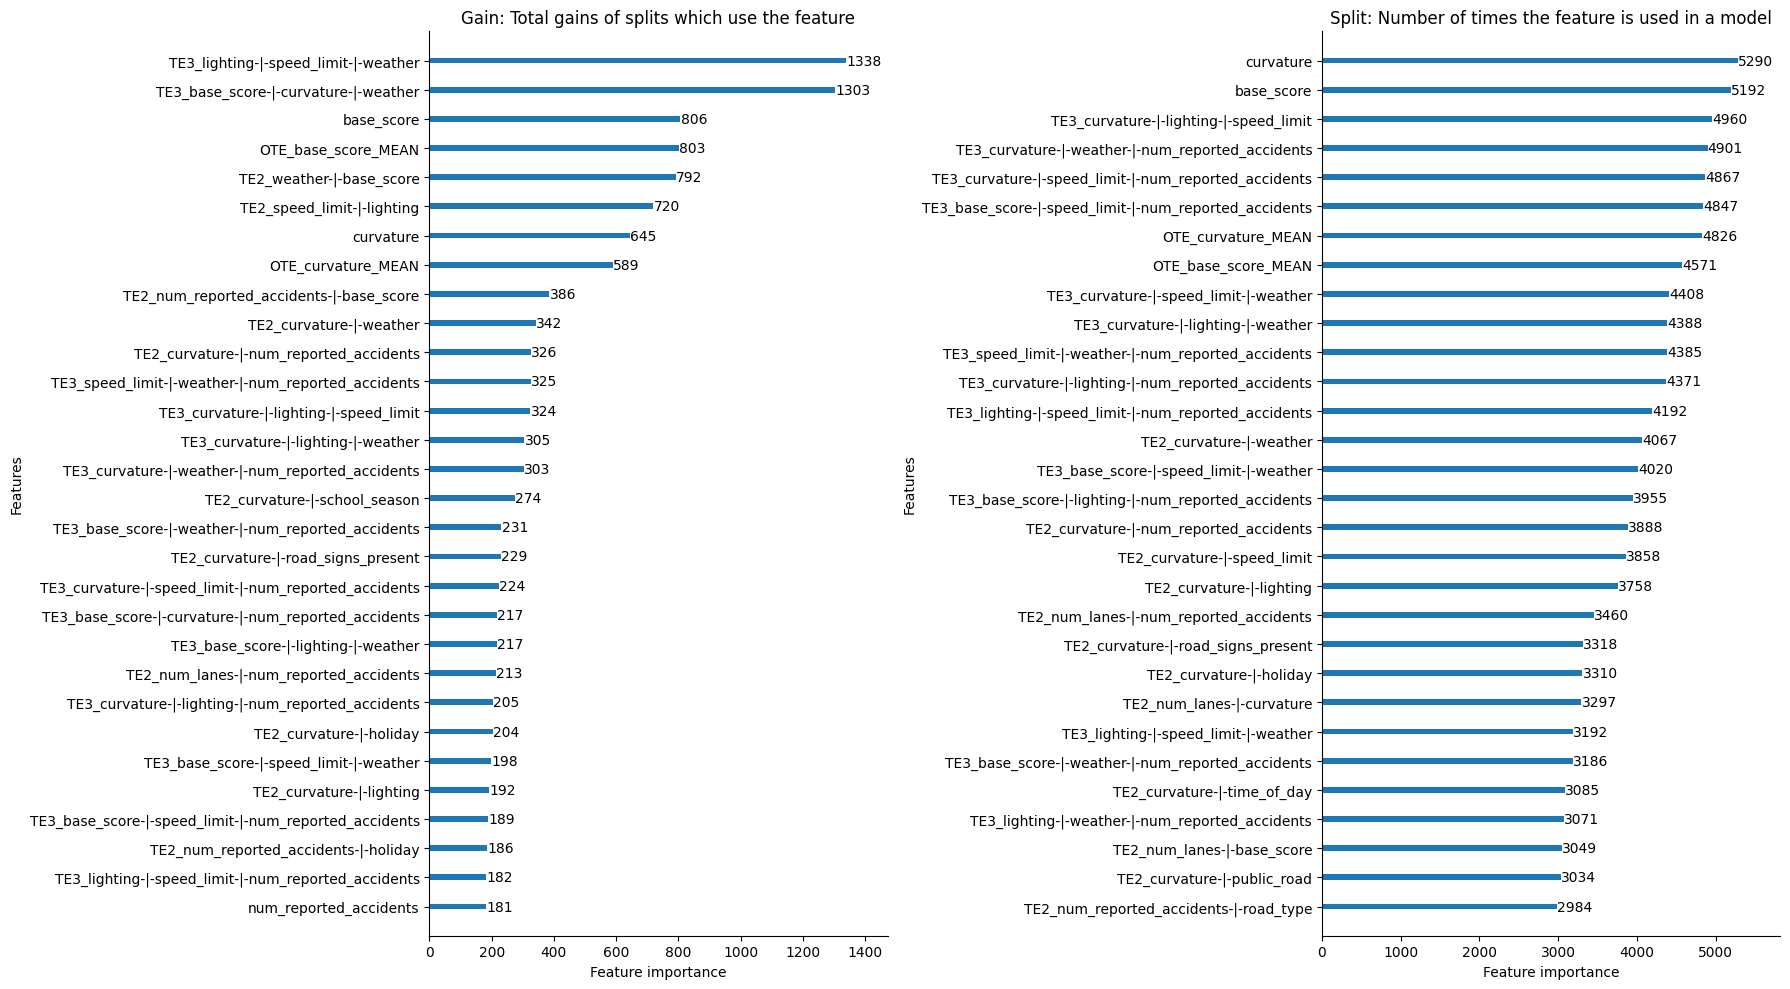

In [29]:
## -- Plot Feature Importances --
MAX = 30
_, axs = plt.subplots(1, 2, figsize=(18, 10))
lgb.plot_importance(
    model,
    ax=axs[0],
    max_num_features=MAX,
    importance_type='gain',
    precision=0, grid=False,
    title="Gain: Total gains of splits which use the feature"
)

lgb.plot_importance(
    model,
    ax=axs[1],
    importance_type='split',
    max_num_features=MAX,
    precision=0, grid=False,
    title="Split: Number of times the feature is used in a model"
)
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [30]:
model.params

{'data_sample_strategy': 'bagging',
 'bagging_fraction': 0.8,
 'feature_fraction': 0.5,
 'max_depth': 7,
 'max_leaves': 65,
 'min_data_in_leaf': 40,
 'eta': 0.005,
 'objective': 'regression',
 'metric': 'rmse',
 'verbose': -1,
 'n_jobs': -1,
 'device_type': 'gpu',
 'seed': 911,
 'num_iterations': 20000,
 'categorical_column': [0, 4, 5, 6, 7, 8, 9, 10]}

In [31]:
## -- Save OOF & PREDICTIONS --
oof_final.to_parquet(f"{name}_oof.parquet", index=False)
test_final.to_parquet(f"{name}_pred.parquet", index=False)

## -- Submission file --
submit[TARGET] = test_final.values
submit.to_csv(f"submit_{name}.csv", index=False)
submit.head()

,id,accident_risk
0,517754,0.293699
1,517755,0.118922
2,517756,0.184067
3,517757,0.308299
4,517758,0.395616
